In [1]:
#  Required imports

import sys, time

import numpy as np

from matplotlib import animation, pyplot as plt

from scipy import stats

from multiprocess import Process, Queue
from threading import Lock, Thread

import threading

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers    import Conv2D, Concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models    import Model
from tensorflow.keras.callbacks import EarlyStopping

  # Matplotlib notebook backend needed for animated plots, otherwise
%matplotlib notebook

print("TensorFlow has found devices:")
for device in tf.config.list_physical_devices() :
    print(f"-  {device}")
    
  # create global list of all threads we will create
all_threads = []

/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


TensorFlow has found devices:
-  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
-  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Let us combine an off-policy value estimate TD update

\begin{align}
  a_t ~&\sim~ \pi_\mathrm{explore}\left( s_t \right) \\
  q_1, q_2 ~&=~ q_1, q_2 ~~\mathrm{or}~~ q_2,q_1 \\
  q_1\left(s_t,a_t\right) ~&\leftarrow~ q_1\left(s_t,a_t\right) ~+~ \alpha_t \left[ R_{t+1} ~+~ \gamma \cdot q_2\left(s_{t+1},\mathrm{argmax}_{a'} q_1\left(s_{t+1},a'\right)\right) ~-~ q_1\left(s_t,a_t\right) \right]
\end{align}

with a functional approximation update

\begin{align}
  L\left( \omega ; s_t, a_t \right) ~&=~ \left| q^\mathrm{true}\left(s_t,a_t\right) ~-~ q^{(\omega)}\left(s_t,a_t\right) \right|^2 ~~~~~~~~\text{[loss function is MSE]} \\
   \nabla_\omega L\left( \omega ; s_t, a_t \right) ~&=~ 2 \left( q^\mathrm{true}\left(s_t,a_t\right) ~-~ q^{(\omega)}\left(s_t,a_t\right) \right) ~\cdot~ \nabla_\omega q^{(\omega)}\left(s_t,a_t\right) \\
   ~&=~ 2 \left( G_t ~-~ q^{(\omega)}\left(s_t,a_t\right) \right) ~\cdot~ \nabla_\omega q^{(\omega)}\left(s_t,a_t\right) \\
   ~&\approx~ 2 \left( R_{t+1} ~+~ \gamma \cdot q^{(\omega)}\left(s_{t+1},a_{t+1}\right) ~-~ q^{(\omega)}\left(s_t,a_t\right) \right) ~\cdot~ \nabla_\omega q^{(\omega)}\left(s_t,a_t\right) ~~~~~\text{[biased estimate, but may still converge]} \\
\end{align}

and so, applying stochastic gradient ascent

\begin{equation}
   \Delta \omega_1 ~=~ +\alpha_t \cdot \left( R_{t+1} ~+~ \gamma \cdot q_2\left(s_{t+1},\text{argmax}_{a'}q_1\left(s_{t+1},a'\right)\right) ~-~ q_1\left(s_t,a_t\right) \right) ~\cdot~ \nabla_\omega q_1\left(s_t,a_t\right)
\end{equation}

for randomly shuffled q1 and q2

N.B. we do not take the grad w.r.t. the value estimate of the next state, because we are using TD, which means that the only data we use is associated with the transition to the next state. We don't want to pull on the next state to account for the reward associated with transitioning to it.

Note: we are doing a max-a operation, which is only easy if a is countable and small. If a is continuous then we could do some numerical approximation but it would take more work, so we will avoid this here.

In [2]:
###
###  Global constants
###

#  Initially we will just run on a game board of fixed size, to avoid building an architecture to handle 
#  variable board sizes, so let's configure this here

horizonal_size = 30
vertical_size  = 30
horizontal_pad = 5
vertical_pad   = 5
horizontal_max = horizonal_size + 2*horizontal_pad
vertical_max   = vertical_size   + 2*vertical_pad  

#  The wind speed will also be held constant (mild towards South West)

horizontal_wind_speed = -1
vertical_wind_speed   = -1


In [3]:
def generate_directory_for_file_path(fname, print_msg_on_dir_creation=True) :
    """
    Create the directory structure needed to place file fname. Call this before fig.savefig(fname, ...) to 
    make sure fname can be created without a FileNotFoundError
    Input:
       - fname: str
                name of file you want to create a tree of directories to enclose
                also create directory at this path if fname ends in '/'
       - print_msg_on_dir_creation: bool, default = True
                                    if True then print a message whenever a new directory is created
    """
    while "//" in fname :
        fname = fname.replace("//", "/")
    dir_tree = fname.split("/")
    dir_tree = ["/".join(dir_tree[:i]) for i in range(1,len(dir_tree))]
    dir_path = ""
    for dir_path in dir_tree :
        if len(dir_path) == 0 : continue
        if not os.path.exists(dir_path) :
            os.mkdir(dir_path)
            if print_msg_on_dir_creation :
                print(f"Directory {dir_path} created")
            continue
        if os.path.isdir(dir_path) : 
            continue
        raise RuntimeError(f"Cannot create directory {dir_path} because it already exists and is not a directory")
    

In [158]:
###
###  Define methods for map generation, iteration and visualisation
###


def generate_empty_weather(horizonal_size=20, vertical_size=20, horizontal_pad=5, vertical_pad=5, 
                           calm_weather_intensity=2., sample=False) :
    '''
    Generates a new storms vector and weather board using the sizes provided. The storms vector is a list of
    pairs representing storm centres. A weather board is a 2D numpy array which tells you how much penalty is 
    applied for ending a turn in that square, on top of the baseline -10 added to all movements which do not 
    terminate. A separate function may be used to iterate the storm vectors and weather based on the wind speed.
    Input:
       >  horizonal_size, float, default=10
          horizontal size of the internal section of the board
       >  vertical_size, float, default=2
          horizontal size of the padding added to the board before encountering a strict boundary
       >  horizontal_pad, float, default=10
          vertical size of the internal section of the board
       >  vertical_pad, float, default=2
          vertical size of the padding added to the board before encountering a strict boundary
       >  calm_weather_intensity, float, default=2.
          constant determing mean intensity of weather at time zero
       >  sample, bool, default=False
          if True then sample weather, otherwise just output empty array of correct shape
    Returns:
       >  empty list
       >  np.ndarray, (horizonal_size+2*horizontal_pad, vertical_size+2*vertical_pad)
    '''
        #  Initialise weather board, return is always 0 and we will generate weather by iterating
    len_x = horizonal_size+2*horizontal_pad
    len_y = vertical_size+2*vertical_pad
    if sample :
        weather_board = np.random.poisson(size=(horizontal_max, vertical_max), lam=calm_weather_intensity)
    else :
        weather_board = np.zeros(shape=(horizontal_max, vertical_max))
        #  Return weather board
    return [], weather_board


def iterate_weather_board(old_storms, old_weather_board, prob_new_storm=0.10, calm_weather_intensity=2., 
                          storm_intensity=15., storm_pad=10, storm_decay_rate=1.5, storm_range=0.3,
                          storms_only=False, resample_each_frame=True) :
    '''
    Iterates the storm centres and weather map by one timestep.
    Input:
      >  old_storms, list of length-3 tuples
         list of (x,y,intensity) co-ordinates describing the storm configurations
      >  old_weather_board, map-size np.ndarray
         2D numpy array describing the current weather penalty at each space in the map
      >  prob_new_storm, float, default=0.12
         probability of generating a new storm during this iteration
      >  calm_weather_intensity, float, default=2.
         constant determing mean intensity of weather before adding storms
      >  storm_intensity, float, default=10.
         constant determing intensity of new storms
      >  storm_pad, int, default=25
         distance from visible region at which we generate storms
      >  storm_decay_rate, float, default=1.8
         constant factor by which storm intensity decreases per unit distance
      >  storm_range, float, default=0.1
         factor defining the range over which storm intensities may vary
      >  storms_only, bool, default=False
         if True then don't sample pixels, which takes ages (useful for mixing steps)
      >  resample_each_frame, bool, True
         configure whether to generate new samples for all pixels, leading to stochastic weather
    Returns:
      >  list of tuples: new storm configurations
      >  2D np.ndarray: new weather map
    '''
       #  Iteration requires knowledge of wind speeds which are global constants
    global horizontal_wind_speed, vertical_wind_speed
       #  Create empty weather board container
    new_weather_board = np.zeros_like(old_weather_board)
       #  Create storm centres container, copy of previous one with wind movement applied
       #    - don't consider previous storms which reach the edge of the maps
    new_storms = [(sx+horizontal_wind_speed, sy+vertical_wind_speed, si) for sx, sy, si in old_storms if sx >= -storm_pad-1 and sy >= -storm_pad-1 and sx <= horizontal_max+storm_pad+1 and sy <= vertical_max+storm_pad+1]
       #  Add a new storm just beyond the top/right edges (with padding of 6) with configured probability
       #    - draw intensity from Poisson distribution with configured mean
    if np.random.uniform(low=0, high=1.) < prob_new_storm :
        if np.random.uniform(low=0, high=1.) < 0.5 :
            storm_x, storm_y = horizontal_max + storm_pad, np.random.randint(low=storm_pad, high=vertical_max+storm_pad)
        else :
            storm_x, storm_y = np.random.randint(low=storm_pad, high=horizontal_max+storm_pad), vertical_max + storm_pad
        si = np.random.uniform(low=(1-0.5*storm_range)*storm_intensity, high=(1+0.5*storm_range)*storm_intensity) # np.random.poisson(lam=storm_intensity)
        new_storms.append((storm_x, storm_y, si))
       #  Iterate weather map according to global win speed
       #  - by copying elements from old_weather_board to new_weather_board, if configured
       #  - pad new spaces by generating weather according to distance from storm centres
       #  - new weather is a random number sampled from Poisson(baseline+sum-storm-penalties)
    if not storms_only :
        for x_idx in range(horizontal_max) :
            for y_idx in range(vertical_max) :
                if not resample_each_frame :
                    if x_idx < horizontal_max + horizontal_wind_speed and x_idx >= horizontal_wind_speed and y_idx < vertical_max + vertical_wind_speed and y_idx >= vertical_wind_speed :
                        new_weather_board[x_idx, y_idx] = old_weather_board[x_idx-horizontal_wind_speed, y_idx-vertical_wind_speed]
                        continue
                weather_intensity = calm_weather_intensity
                for storm_x, storm_y, si in new_storms :
                    r = np.sqrt((x_idx-storm_x)**2 + (y_idx-storm_y)**2)
                    weather_intensity += max(0, si - storm_decay_rate*r)
                new_weather_board[x_idx, y_idx] = np.random.poisson(lam=weather_intensity)
       #  Return new storm and weather containers
    return new_storms, new_weather_board


def create_weather_plot(weather_board, trajectory=[], show=False, close=False, savefile="") :
    '''
    Create weather map plot
    Input:
      >  weather_board, map-size np.ndarray
         2D numpy array describing the current weather penalty at each space in the map
      >  trajectory, list of (x,y) co-ordinates
         agent trajectory to draw as a line
      >  show, bool, default=False
         Configure whether to call plt.show(fig) on the plot created
      >  close, bool, default=False
         Configure whether to call plt.close(fig) on the plot created
      >  savefile, str, default=""
         If non-empty string created then we attempt to save the plot to this file
    Returns:
      >  pyplot Fig object
      >  pyplot Axes object (main plot)
      >  pyplot Axes object (colorbar)
      >  plt.image.AxesImage object from imshow
    '''
    #%matplotlib inline
    fig = plt.figure(figsize=(6.5, 6))
    ax  = fig.add_axes([0   , 0., 6./6.5, 1.])
    cax = fig.add_axes([0.97, 0., .03   , 1.])
    ax .tick_params(axis="both", which="both", right=True, top=True, direction="in", labelsize=14)
    cax.tick_params(axis="both", which="both", right=True, top=True, direction="in", labelsize=14)
    im = ax.imshow(weather_board, origin="lower", vmin=0, vmax=25)
    ax.plot([horizontal_pad], [vertical_pad+vertical_size-1], "*", markersize=25, c="r")
    ax.plot([horizontal_pad+horizonal_size-1], [vertical_pad], "*", markersize=20, c="r")
    '''ax.plot([horizontal_pad+0.5*(horizonal_size-1)-2, horizontal_pad+0.5*(horizonal_size-1)+2], 
            [vertical_pad+0.5*(vertical_size-1)-2, vertical_pad+0.5*(vertical_size-1)+2], "-", lw=3, c="r")'''
    if len(trajectory) > 0 :
        ax.plot(trajectory[-1][0], trajectory[-1][1], "o", markersize=10, c="r")
    line, = ax.plot([r[0] for r in trajectory], [r[1] for r in trajectory], "--", lw=3, c="r")
    ax.text(horizontal_pad, vertical_pad+vertical_size-1 + 0.05*vertical_max, "START", ha="center", va="bottom", weight="bold", fontsize=18, c="r")
    ax.text(horizontal_pad+horizonal_size-1, vertical_pad - 0.05*vertical_max, "END", ha="center", va="top", weight="bold", fontsize=18, c="r")
    plt.colorbar(im, cax=cax, cmap="r_viridis")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax .set_title("Weather map", rotation=0, fontsize=20, pad=15)
    cax.set_title("Penalty"    , rotation=0, fontsize=20, pad=15)
    if len(savefile) > 0 :
        generate_directory_for_file_path(savefile)
        fig.savefig(savefile, bbox_inches="tight", dpi=dpi)
        print(f"Figure saved to file {savefile}")
    if show :
        plt.show(fig)
    if close :
        plt.close(fig)
    return fig, ax, cax, im, line


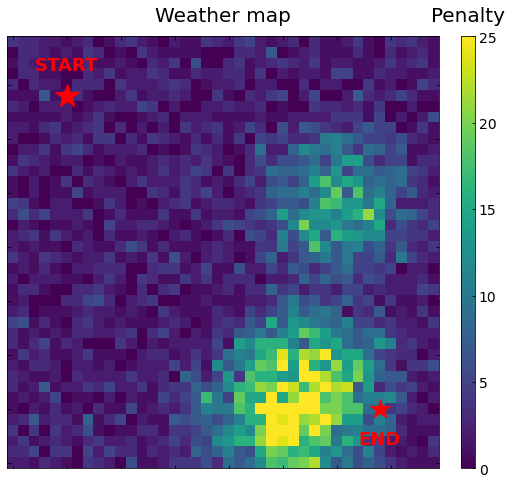

done


In [132]:
###
###  Create and plot some weather
###

  # Configure number of initial timesteps over which storms can be generated and propagate
mixing_time = 300

  # Use mpl inline backend for static plots
%matplotlib inline

  # Generate new weather and apply mixing timesteps
storms, weather_board = generate_empty_weather()
for i in range(mixing_time-1) :
    storms, weather_board = iterate_weather_board(storms, weather_board, storms_only=True) 
storms, weather_board = iterate_weather_board(storms, weather_board) 
    
  # Create plot, show and immediately close to remove from memory
create_weather_plot(weather_board, show=True, close=True)
print("done")


<IPython.core.display.Javascript object>


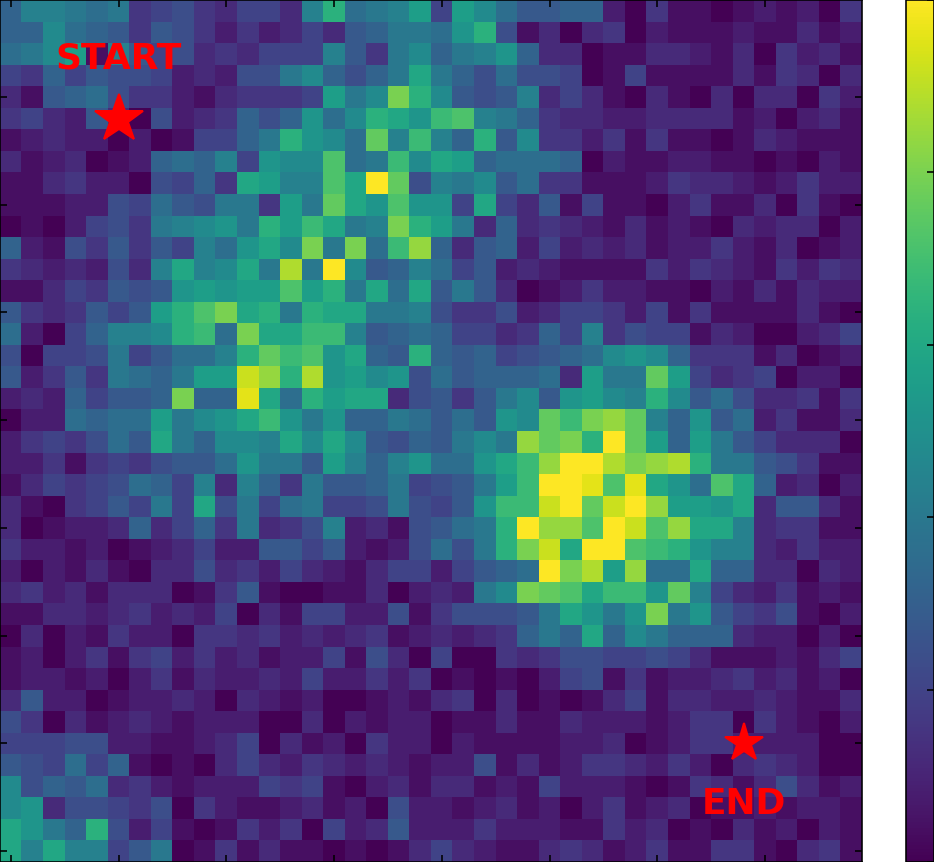

done


In [128]:
###
###  Animate weather propagation over time
###

  # Configurable constants
fps = 8

  # Use mpl notebook backend for animated plots
%matplotlib notebook

  # Create figure object to iterate and form an animation
storms, weather_board = generate_empty_weather()
fig, ax, cax, im, line = create_weather_plot(weather_board)
    
  # Create method which applied frame updates by iterating the weather and overwriting im object
def animate(i) :
    global storms, weather_board
    storms, weather_board = iterate_weather_board(storms, weather_board)
    im.set_array(weather_board.transpose())
    return [im]
    
  # Create mpl animation object
ani = animation.FuncAnimation(fig, animate, frames=150, interval=1000/fps, repeat=True)

  # Show animation
plt.show(ani)
print("done")


In [7]:
###
###  Methods for generating data for training the CNN
###


def create_new_datapoints(num_datapoints, out_queue, seed, pad=4) :
    np.random.seed(seed)
    for dataset_idx in range(num_datapoints) :
        storms, weather_board = generate_empty_weather()
        for t_idx in range(mixing_time-1) :
            storms, weather_board = iterate_weather_board(storms, weather_board, storms_only=True)
        storms, weather_board = iterate_weather_board(storms, weather_board)
        num_storms = len([s for s in storms if s[0] >=-pad and s[0] < weather_board.shape[0]+pad and s[1] >=-pad and s[1] < weather_board.shape[1]+pad])
        weather_board = weather_board.reshape((weather_board.shape[0], weather_board.shape[1], 1))
        out_queue.put([weather_board, num_storms])
        
        
class BaseThread(Thread) :
    
    def __init__(self):
        Thread.__init__(self)
        self.killed = False
        self.lock   = Lock()
        global all_threads
        all_threads.append(self)
        
    def kill(self, killed=True, verbose=False) :
        if not self.killed and killed and verbose :
            self.info(f"Killing thread: {self.name}\n")
        self.killed = killed
            
    def info(self, message) :
        self.lock.acquire()
        sys.stdout.write(f"{message}")
        sys.stdout.flush()
        self.lock.release()
    
    
class WorkerThread(BaseThread):
    
    def __init__(self, num_processes, num_datapoints_per_process, base_seed=-1, interval=1):
        BaseThread.__init__(self)
        self.num_processes = num_processes
        self.num_datapoints_per_process = num_datapoints_per_process
        self.X = []
        self.Y = []
        self.base_seed = base_seed if base_seed > 0 else int(time.time())
        self.interval  = interval
        
    def run(self):
        self.kill(False)
        out_queue = Queue()

        processes = []
        for proc_idx in range(self.num_processes) :
            p = Process(target=create_new_datapoints, args=(self.num_datapoints_per_process,out_queue,self.base_seed+proc_idx))
            p.start()
            processes.append(p)

        exp_length = self.num_processes*self.num_datapoints_per_process
        while len(self.X) < exp_length and not self.killed :
            time.sleep(self.interval)
            while not out_queue.empty() :
                x, y = out_queue.get()
                self.X.append(x)
                self.Y.append(y)
        
        # Don't need to call process.join() because we are manually waiting for results to appear, or for
        #   processes to be interrupted
       
    
class MonitorThread(BaseThread):
    
    def __init__(self, worker, interval=1):
        BaseThread.__init__(self)
        self.worker   = worker
        self.interval = interval
        
    def run(self):
        self.kill(False)
        exp_length = self.worker.num_processes*self.worker.num_datapoints_per_process
        start_time = time.time()
        self.info(f"\rGenerating {exp_length} datapoints")
        while len(self.worker.X) < exp_length and not self.killed :
            time.sleep(self.interval)
            if not self.killed :
                self.info(f"\rGenerated {len(self.worker.X)} / {exp_length} datapoints [t={time.time()-start_time:.2f}s]")
        if len(self.worker.X) < exp_length :
            self.info(f"\nMonitor killed [t={time.time()-start_time:.2f}s] [n={len(self.worker.X)}]\n")
        else :
            self.info(f"\nTraining data complete [t={time.time()-start_time:.2f}s] [n={len(self.worker.X)}]\n")


def kill_threads(threads=None, verbose=False) :
    if type(threads) is type(None) :
        global all_threads
        threads = all_threads
    for thread in threads :
        if not hasattr(thread, "kill") :
            continue
        thread.kill(verbose=verbose)
    

In [12]:
###
###  Run this cell to interrupt threads which continue printing garbage even after KeyboardInterrupt
###

kill_threads(verbose=True)


Killing thread: Thread-7
Killing thread: Thread-8


In [11]:
###
###  Generate training data
###

num_processes = 8

worker  = WorkerThread(num_processes, 1250)
monitor = MonitorThread(worker, interval=3)

monitor.start()
worker .start()

worker .join()
monitor.join()


Generated 3546 / 10000 datapoints [t=661.91s]

Process Process-16:
Process Process-15:
Process Process-14:
Process Process-13:
Process Process-12:


KeyboardInterrupt: 

Process Process-11:
Process Process-10:
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/multiprocess/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/multiprocess/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/multiprocess/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/site-packages/multiprocess/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/Users/Ste/miniforge3/envs/tf

  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/threading.py", line 1073, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/threading.py", line 1073, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/threading.py", line 1073, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
  File "/Users/Ste/miniforge3/envs/tf-sandbox-py3p9/lib/python3.9/threading.py", line 1073, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


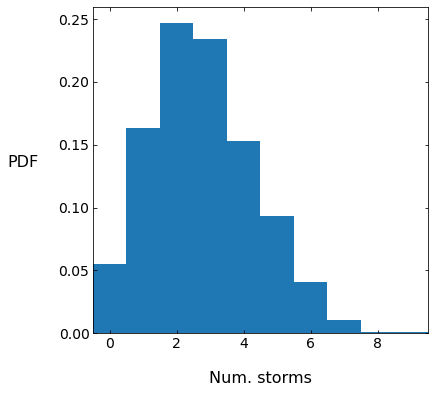

In [13]:
###
###  Plot storm frequency for validation
###

%matplotlib inline

num_storms = worker.Y
max_storms = np.max(num_storms)

fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(1, 1, 1)
ax.tick_params(which="both", axis="both", right=True, top=True, direction="in", labelsize=14)
ax.set_xlabel("Num. storms", fontsize=16, labelpad=20)
ax.set_ylabel("PDF", fontsize=16, labelpad=20, rotation=0, ha="right")
ax.set_xlim(-0.5, max_storms+0.5)

ax.hist(num_storms, bins=np.linspace(-0.5, max_storms+0.5, max_storms+2), density=True)

plt.show(fig)


Num. storms is 2


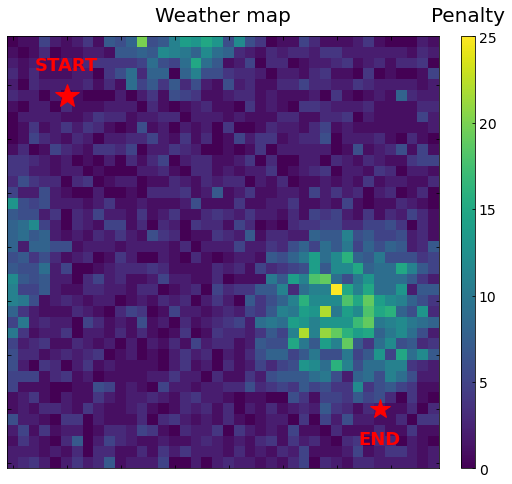

Num. storms is 2


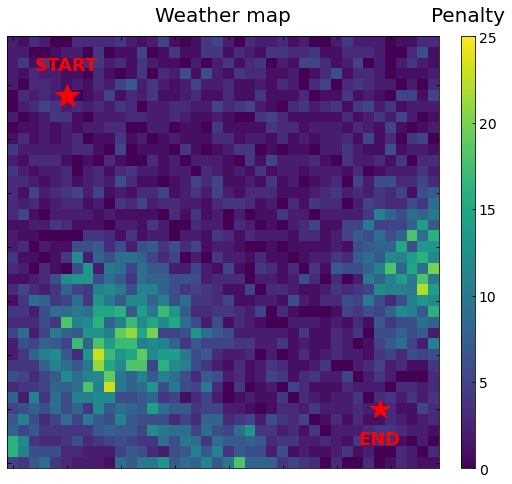

Num. storms is 2


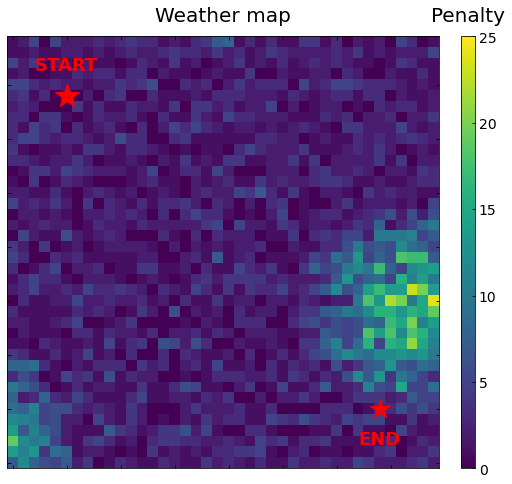

Num. storms is 4


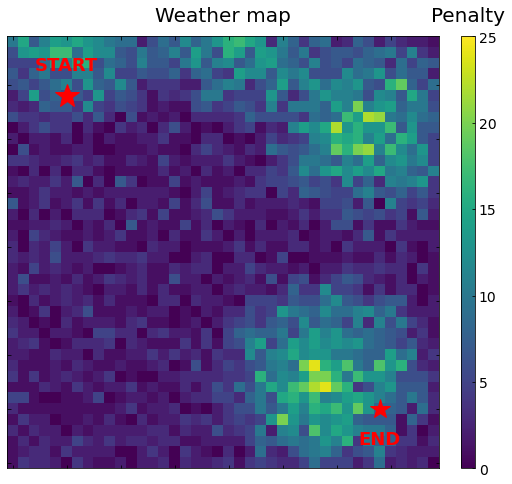

Num. storms is 2


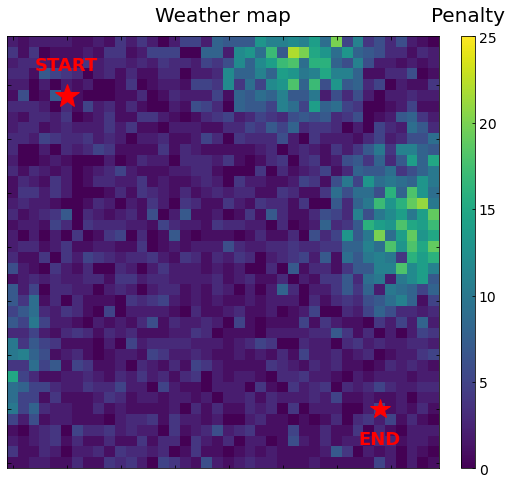

Num. storms is 2


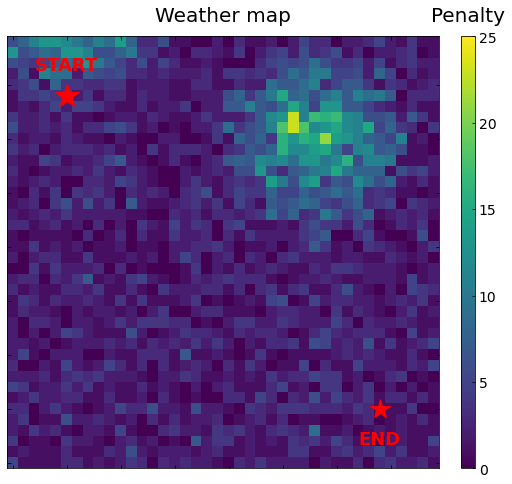

Num. storms is 4


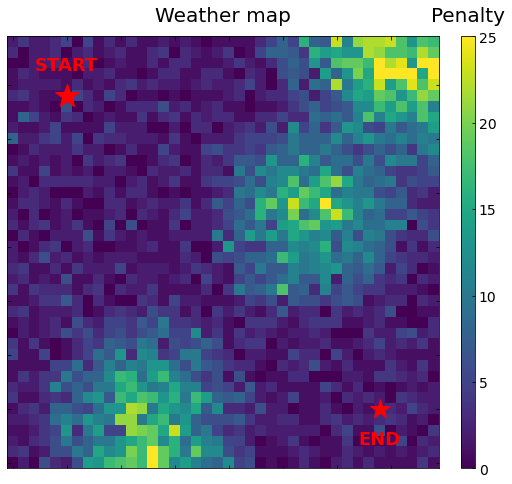

Num. storms is 2


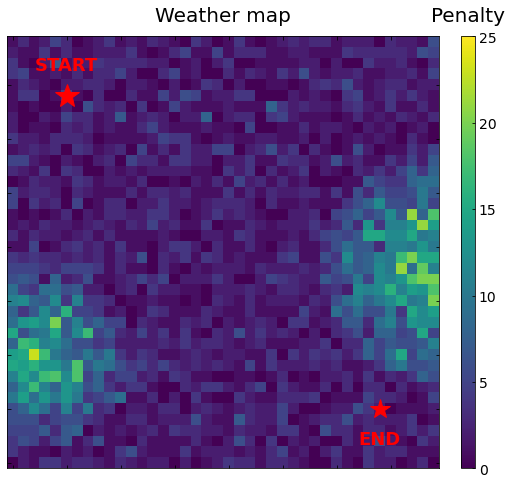

Num. storms is 6


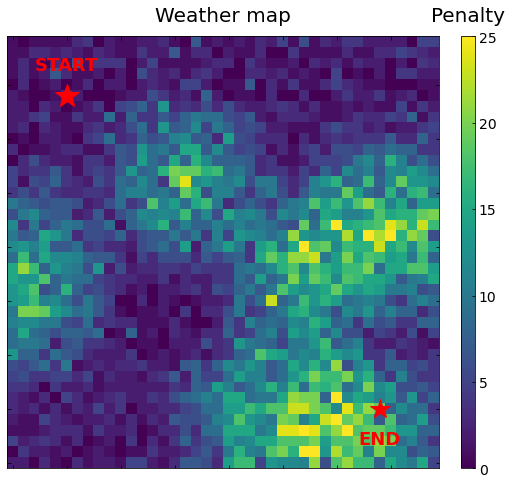

Num. storms is 4


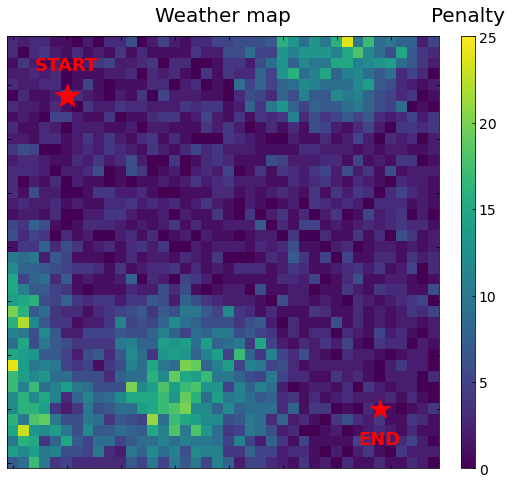

In [14]:
###
###  Plot some data to check that it is sensible
###

%matplotlib inline

num_datapoints = 10

for data_idx in range(num_datapoints) :
    x, y = worker.X[data_idx], worker.Y[data_idx]
    print(f"Num. storms is {y}")
    create_weather_plot(x.reshape((x.shape[0], x.shape[1])), show=True, close=True)


In [15]:
###
###  Create training data containers compatible with keras model
###


def to_one_hot(x, length=10) :
    '''
    Create a one-hot vector representing index x
    Inputs:
      > x, int
        index to be set to one (first index is zero)
      > length, int, default=10
        length of one-hot vector
    '''
    assert type(x) == int, f"input of type {type(x)} where {int} provided"
    assert x >= 0 and x < length, f"input {x} not in range [0, {length})"
    one_hot = np.zeros(shape=(length,))
    one_hot[x] = 1.
    return one_hot

max_weather = np.max(worker.X)
f_prescale = 2. / max_weather
print(f"max_weather = {max_weather:.3f}")
print(f"f_prescale  = {f_prescale:.3f}")

train_X = f_prescale * np.array(worker.X)
train_Y = np.array([to_one_hot(x) for x in worker.Y if x < 10])


max_weather = 54.000
f_prescale  = 0.037


In [16]:
#f_prescale  = 0.034

In [17]:
###
###  Method for creating CNN for pre-training
###

def create_weather_recognition_model(input_shape, name=None) :
    '''
    Create a network for the storm recognition and localisation task. Input to the model is a weather map with
    configured shape. Output from the model is categorical prob distribution over num. storms.
    Inputs:
      > input_shape, pair
        x and y lengths
      > name, str, default=None
        model name, if None then keras default is used
    Returns:
      > keras Model: compiled keras model
    '''
    input_layer  = Input ((input_shape[0], input_shape[1], 1))
    next_layer   = Conv2D(10, kernel_size=(3, 3), activation="relu")(input_layer)
    next_layer   = MaxPooling2D(pool_size=(2, 2))(next_layer)
    next_layer   = Dropout(0.1)(next_layer)
    next_layer   = Conv2D(10, kernel_size=(3, 3), activation="relu")(next_layer)
    next_layer   = MaxPooling2D(pool_size=(2, 2))(next_layer)
    next_layer   = Dropout(0.1)(next_layer)
    next_layer   = Flatten()(next_layer)
    next_layer   = Dense  (20, activation="relu")(next_layer)
    next_layer   = Dropout(0.1)(next_layer)
    next_layer   = Dense  (2, activation="relu")(next_layer)
    next_layer   = Dropout(0.1)(next_layer)
    output_layer = Dense  (10 , activation="softmax")(next_layer)
    model        = Model(input_layer, output_layer, name=name)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
    

In [18]:
###
###  Create and train CNN model
###


model = create_weather_recognition_model(weather_board.shape, name="storm_counter")
model.summary()

train_record = model.fit(train_X, train_Y, validation_split=0.3, shuffle=False, epochs=1000, 
                         callbacks=EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True))


Metal device set to: Apple M1 Pro
Model: "storm_counter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 38, 38, 10)        100       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 19, 10)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 19, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 10)        910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 10)         0         
 2D)               

2022-07-06 20:18:04.915332: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


78/78 [==============================] - 2s 18ms/step - loss: 2.2769 - accuracy: 0.2322 - val_loss: 2.2524 - val_accuracy: 0.2331
Epoch 2/1000
78/78 [==============================] - 1s 13ms/step - loss: 2.2166 - accuracy: 0.2443 - val_loss: 2.1787 - val_accuracy: 0.2266
Epoch 3/1000
78/78 [==============================] - 1s 13ms/step - loss: 2.1414 - accuracy: 0.2503 - val_loss: 2.1034 - val_accuracy: 0.2266
Epoch 4/1000
78/78 [==============================] - 1s 13ms/step - loss: 2.0798 - accuracy: 0.2503 - val_loss: 2.0357 - val_accuracy: 0.2266
Epoch 5/1000
78/78 [==============================] - 1s 13ms/step - loss: 2.0148 - accuracy: 0.2547 - val_loss: 1.9640 - val_accuracy: 0.2275
Epoch 6/1000
78/78 [==============================] - 1s 13ms/step - loss: 1.9561 - accuracy: 0.2607 - val_loss: 1.9002 - val_accuracy: 0.2397
Epoch 7/1000
78/78 [==============================] - 1s 13ms/step - loss: 1.9043 - accuracy: 0.2644 - val_loss: 1.8458 - val_accuracy: 0.2631
Epoch 8/1000

78/78 [==============================] - 1s 12ms/step - loss: 1.4443 - accuracy: 0.4126 - val_loss: 1.3502 - val_accuracy: 0.4167
Epoch 59/1000
78/78 [==============================] - 1s 12ms/step - loss: 1.4438 - accuracy: 0.4146 - val_loss: 1.3447 - val_accuracy: 0.4232
Epoch 60/1000
78/78 [==============================] - 1s 13ms/step - loss: 1.4803 - accuracy: 0.3893 - val_loss: 1.3440 - val_accuracy: 0.4092
Epoch 61/1000
78/78 [==============================] - 1s 13ms/step - loss: 1.4571 - accuracy: 0.4086 - val_loss: 1.3463 - val_accuracy: 0.4129
Epoch 62/1000
78/78 [==============================] - 1s 13ms/step - loss: 1.4454 - accuracy: 0.4170 - val_loss: 1.3414 - val_accuracy: 0.3933
Epoch 63/1000
78/78 [==============================] - 1s 12ms/step - loss: 1.4459 - accuracy: 0.4110 - val_loss: 1.3442 - val_accuracy: 0.3689
Epoch 64/1000
78/78 [==============================] - 1s 13ms/step - loss: 1.4393 - accuracy: 0.4198 - val_loss: 1.3379 - val_accuracy: 0.3858
Epoch 

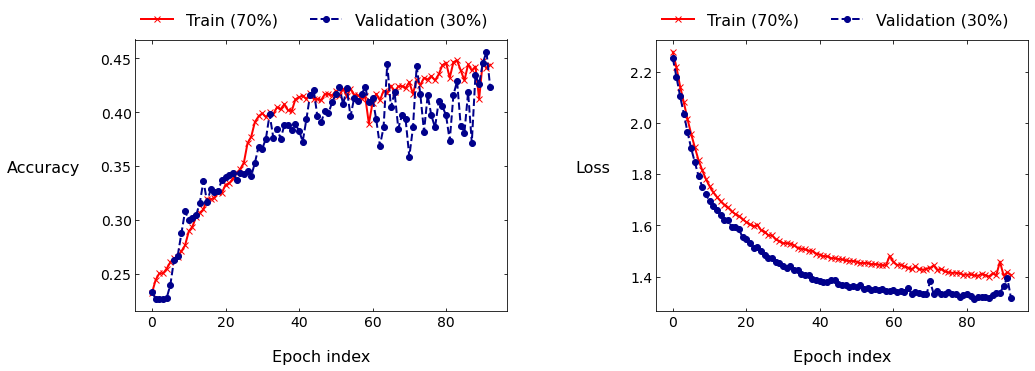

In [19]:
###
###  Get and plot training curves
###

  # matplotlib inline backend
%matplotlib inline

  # get metrics from training history
accuracy     = train_record.history["accuracy"    ] if "accuracy" in train_record.history else []
loss         = train_record.history["loss"        ] if "loss" in train_record.history else []
val_accuracy = train_record.history["val_accuracy"] if "val_accuracy" in train_record.history else []
val_loss     = train_record.history["val_loss"    ] if "val_loss" in train_record.history else []

  # create figure
fig = plt.figure(figsize=(16, 5))

  # create and format LHS axis, for accuracy metrics
ax  = fig.add_subplot(1, 2, 1)
ax.tick_params(axis="both", which="both", right=True, top=True, direction="in", labelsize=14)
ax.set_ylabel("Accuracy", fontsize=16, labelpad=20, rotation=0, ha="right")
ax.set_xlabel("Epoch index", fontsize=16, labelpad=20, rotation=0)

  # plot accuracy metrics
ax.plot(np.arange(len(accuracy    )), accuracy    , "x-" , lw=2, c="r", label="Train (70%)")
ax.plot(np.arange(len(val_accuracy)), val_accuracy, "o--", lw=2, c="darkblue", label="Validation (30%)")

  # draw legend on LHS plot
ax.legend(loc=(0, 1.02), frameon=False, fontsize=16, ncol=2)

  # create and format RHS axis, for loss metrics
ax  = fig.add_subplot(1, 2, 2)
ax.tick_params(axis="both", which="both", right=True, top=True, direction="in", labelsize=14)
ax.set_ylabel("Loss", fontsize=16, labelpad=20, rotation=0, ha="right")
ax.set_xlabel("Epoch index", fontsize=16, labelpad=20, rotation=0)

  # plot loss metrics
ax.plot(np.arange(len(loss    )), loss    , "x-" , lw=2, c="r", label="Train (70%)")
ax.plot(np.arange(len(val_loss)), val_loss, "o--", lw=2, c="darkblue", label="Validation (30%)")

  # draw legend on RHS plot
ax.legend(loc=(0, 1.02), frameon=False, fontsize=16, ncol=2)

  # format figure
fig.subplots_adjust(wspace=.4)

  # show and close figure
plt.show(fig)
plt.close(fig)

In [20]:
###
###  Generate test data
###

kill_threads(verbose=True)

num_processes = 8  

test_worker  = WorkerThread(num_processes, 25, base_seed=100)
test_monitor = MonitorThread(test_worker, interval=3)    

test_monitor.start()
test_worker .start()

test_worker .join()
test_monitor.join()


Generated 200 / 200 datapoints [t=36.06s]
Training data complete [t=36.07s] [n=200]


In [21]:
###
###  Convert test data into tensorflowable arrays
###

test_X = f_prescale * np.array(test_worker.X)
test_Y = np.array([to_one_hot(x) for x in test_worker.Y if x < 10])

pred_Y = model.predict(test_X)


In [22]:
###
###  Calculate test accuracy
###

%matplotlib inline

num_correct, num_tot = 0, 0
for true_y, pred_y in zip(test_Y, pred_Y) :
    num_tot += 1
    if np.argmax(true_y) != np.argmax(pred_y) : continue
    num_correct += 1
    
print(f"Test accuracy is {100.*num_correct/num_tot:.2f}%")
    

Test accuracy is 44.50%


# Try some double Q learning!!!

\begin{split}
r_\mathrm{start} ~&=~ \left( x_\mathrm{pad}, ~y_\mathrm{pad}+y_\mathrm{size}-1 \right) \\
r_\mathrm{end} ~&=~ \left( x_\mathrm{pad}+x_\mathrm{size}-1, ~y_\mathrm{pad} \right) \\
   s ~&=~ \{ w_{i,j} ,~ r_\mathrm{agent} \} \\
   a ~&\in~ \{ \Delta x \in \{-1,0,1\},~ \Delta y \in \{-1,0,1\} \} \\
   r^{(t+1)} ~&=~ -1 ~-~ \lambda_w \cdot w_{i,j}^{(t+1)} ~+~ \lambda_r \left(d^{(t+1)} - d^{(t)}\right) ~-~ \lambda_b  \\
   s^{(t+1)} ~&=~ r_\mathrm{agent} ~+~ a ~~~\text{if not beyond board wall} \\
\end{split}

Start with agent near top-left corner and airport at bottom-right corner of the main board, i.e. not including the padding

Terminate when $r_\mathrm{agent} = r_\mathrm{end}$

Exploration policy is
\begin{equation}
\pi_\mathrm{explore}\left(a\right) ~\propto~
\begin{cases}
2 ~&~ \text{if $\Delta r$ decreases} \\
1 ~&~ \text{otherwise} \\
\end{cases}
\end{equation}

In [366]:
lambda_w = 0.
lambda_r = 1.
lambda_b = 50.
r_start = np.array([horizontal_pad, vertical_pad+vertical_size-1])
r_end   = np.array([horizontal_pad+horizonal_size-1, vertical_pad]) 
r_norm  = np.array([horizontal_max, vertical_max])

action_list = np.array([[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 0], [0, 1], [1, -1], [1, 0], [1, 1]])
gamma       = 1.

print(f"r_start = {r_start}")
print(f"r_end   = {r_end}")

r_start = [ 5 34]
r_end   = [34  5]


In [364]:

def perform_action(storms, weather_board, r_agent, action, boundary_penalty=lambda_b, 
                   w_reward_factor=lambda_w, dr_reward_factor=lambda_r) :
    '''
    Given the current environment and agent states, perform the specified action (this iterates both the
    agent and the environment) and return the reward obtained, and the next environment and agent states.
    Inputs:
      > storms, list of tiplets
        locations and intensities of all current storms at initial timestep
      > weather_board, np.ndarray of shape (horizontal_max, vertical_max)
        weather map at initial timestep
      > r_agent, np.ndarray of shape (2,)
        (x,y) position of agent at initial timestep
      > action, np.ndarray of shape (2,)
        (dx,dy) of action to be performed, each component expected to be one of {-1, 0, +1}
      > boundary_penalty, float, default=lambda_b
        reward penalty for encountering the edge of the game board
      > w_reward_factor, float, default=lambda_w
        factor applied to weather-value when computing contribution to reward penalty
      > dr_reward_factor, float, default=lambda_r
        factor applied to change-in-distance when computing contribution to reward penalty
    Returns:
      > float
        reward obtained by performing action
      > list of tiplets
        locations and intensities of all current storms at iterated timestep
      > np.ndarray of shape (horizontal_max, vertical_max)
        weather map at iterated timestep
      > np.ndarray of shape (2,)
        (x,y) position of agent at iterated timestep
    '''
      ## Get initial distance of agent from the end
    d_agent = np.sqrt(((r_agent - r_end)**2).sum())
      ## Iterate weather map by one timestep (this is used to determine the weather-based reward)
    #storms_p, weather_board_p = iterate_weather_board(storms, weather_board)
    storms_p, weather_board_p = [s for s in storms], weather_board.copy()
      ## Initialise reward to -2 (all actions experience a negative reward, since we are still playing)
    reward_base = -2
      ## Iterate agent position
      ## - if agent hits a wall then add an appropriate penalty and return to starting position
    r_agent_p = r_agent + action
    reward_b = 0
    if r_agent_p[0] < 0 or r_agent_p[0] >= horizontal_max or r_agent_p[1] < 0 or r_agent_p[1] >= vertical_max :
        reward_b  = -lambda_b
        r_agent_p = r_agent.copy()
      ## Apply weather-based reward
    reward_w = -w_reward_factor * weather_board_p[r_agent_p[0], r_agent_p[1]]
      ## Apply distance-based reward
    d_agent_p = np.sqrt(((r_agent_p - r_end)**2).sum())
    reward_r  = lambda_r * (d_agent - d_agent_p)
    '''if r_agent[0]==r_start[0] and r_agent[1]==r_start[1] :
        print(f"r_agent={r_agent}, action={action}, reward = {reward_base:.2f} (base) + {reward_b:.2f} (edge) + {reward_w:.2f} (weather) + {reward_r:.2f} (distance)")'''
    reward = reward_base + reward_b + reward_w + reward_r
      ## Return
    return reward, storms_p, weather_board_p, r_agent_p
    

def get_exploration_policy(r_agent) :
    d_agent = np.sqrt(((r_agent - r_end)**2).sum())
    policy, actions = np.zeros(shape=(3,3)), np.zeros(shape=(3,3,2), dtype=int)
    for x_idx, dx in enumerate([-1, 0, 1]) :
        for y_idx, dy in enumerate([-1, 0, 1]) :
            a = np.array([dx, dy])
            r_agent_p = r_agent + a
            d_agent_p = np.sqrt(((r_agent_p - r_end)**2).sum())
            policy [x_idx, y_idx] = 2. if d_agent_p < d_agent else 1.
            actions[x_idx, y_idx,0] = dx
            actions[x_idx, y_idx,1] = dy
    policy /= np.sum(policy)
    return policy, actions


def prepare_weather_board_for_model(weather_board) :
    return f_prescale*weather_board.reshape((horizontal_max, vertical_max, 1))
    

def get_greedy_action(weather_board, r_agent, *q_models) :
    weather_board  = prepare_weather_board_for_model(weather_board)
    weather_boards = np.array([weather_board  for i in range(9)])
    r_agents       = np.array([r_agent/r_norm for i in range(9)])
    #model_args     = [weather_boards, r_agents, action_list]
    model_args     = [r_agents, action_list]
    action_values  = np.mean([model.predict(model_args) for model in q_models], axis=0)
    best_action    = action_list[np.argmax(action_values)]
    return best_action


def get_exploration_action(r_agent) :
    policy, actions = get_exploration_policy(r_agent)
    random_index    = np.random.choice(9, p=policy.reshape((9,)))
    random_action   = actions.reshape((9,2))[random_index]
    return random_action
    

In [359]:
###
###  Method for creating action-value model
###

def create_action_value_model(name=None) :
    '''
    Create a network for the action-value model.
    Inputs:
      > name, str, default=None
        model name, if None then keras default is used
    Returns:
      > keras Model: uncompiled keras model (must be trained using custom loop)
    '''
    input_layer_w = Input ((horizontal_max, vertical_max, 1))
    input_layer_r = Input ((2,))
    input_layer_a = Input ((2,))
    next_layer_r  = Dense(50, activation="relu")(input_layer_r)
    next_layer_a  = Dense(50, activation="relu")(input_layer_a)
    '''next_layer_w  = MaxPooling2D(pool_size=(2, 2))(input_layer_w)
    next_layer_w  = Conv2D(20, kernel_size=(3, 3), activation="relu")(next_layer_w)
    next_layer_w  = MaxPooling2D(pool_size=(2, 2))(next_layer_w)
    next_layer_w  = Conv2D(20, kernel_size=(3, 3), activation="relu")(next_layer_w)
    next_layer_w  = MaxPooling2D(pool_size=(2, 2))(next_layer_w)
    next_layer_w  = Flatten()(next_layer_w)'''
    next_layer_w  = MaxPooling2D(pool_size=(2, 2))(input_layer_w)
    next_layer_w  = Flatten()(next_layer_w)
    next_layer_w  = Dense(50, activation="relu")(next_layer_w)
    #next_layer    = Concatenate()([next_layer_r, next_layer_a, next_layer_w])
    next_layer    = Concatenate()([next_layer_r, next_layer_a])
    next_layer    = Dense(300, activation="relu")(next_layer)
    next_layer    = Dense(100, activation="relu")(next_layer)
    output_layer  = Dense(1, activation="linear")(next_layer)
    model         = Model([input_layer_r, input_layer_a], output_layer, name=name)
    #model         = Model([input_layer_w, input_layer_r, input_layer_a], output_layer, name=name)
    return model
    

In [292]:

## Configure

mixing_time    = 100
max_turns      = 50
num_test_games = 1

## Method for getting new game after mixing steps

def get_new_game(mixing_steps=mixing_time) :
    storms, weather_board = generate_empty_weather()
    for t_idx in range(mixing_time-1) :
        storms, weather_board = iterate_weather_board(storms, weather_board, storms_only=True)
    storms, weather_board = iterate_weather_board(storms, weather_board, storms_only=False)
    return storms, weather_board

def is_terminal(r_agent) :
    if r_agent[0] == r_end[0] and r_agent[1] == r_end[1] :
        return True
    return False

## Method for getting total return during a game
def play_game(storms, weather_board, q1_model, q2_model, max_turns, show=True) :
    game_return, num_turns = 0., 0
    r_agent    = r_start.copy()
    trajectory = [r_agent]
    while num_turns < max_turns and not is_terminal(r_agent) :
        action = get_greedy_action(weather_board, r_agent, q1_model, q2_model)
        reward, storms, weather_board, r_agent = perform_action(storms, weather_board, r_agent, action)
        game_return += reward
        num_turns   += 1
        trajectory.append(r_agent)
    if show :
        create_weather_plot(weather_board, trajectory, show=True, close=True)
    return game_return, trajectory

## Define test games

test_games = [get_new_game(mixing_time) for game_idx in range(num_test_games)]

def get_test_score(q1_model, q2_model, show=True) :
    games_results = [play_game(g[0], g[1], q1_model, q2_model, max_turns, show=show) for g in test_games]
    game_returns  = [g[0] for g in games_results]
    game_trajs    = [g[1] for g in games_results]
    return np.mean(game_returns), np.std(game_returns) / np.sqrt(len(test_games)), game_trajs

def test_models(q1_model, q2_model) :
    test_mean, test_stderr = get_test_score(q1_model, q2_model)
    print(f"Mean test return: {test_mean:.3f} +- {test_stderr:.3f}")


In [375]:

q1_model = create_action_value_model(name="action_value_model_1")
q2_model = create_action_value_model(name="action_value_model_2")

q1_model.summary()


Model: "action_value_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_315 (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 input_316 (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 dense_439 (Dense)              (None, 50)           150         ['input_315[0][0]']              
                                                                                                  
 dense_440 (Dense)              (None, 50)           150         ['input_316[0][0]']              
                                                                               

Test games are:


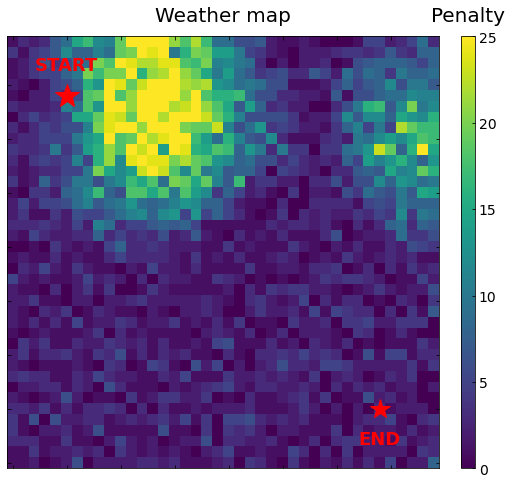

In [304]:

print("Test games are:")

test_games = [get_new_game(mixing_time) for game_idx in range(num_test_games)]
for g in test_games :
    create_weather_plot(g[1], show=True, close=True)


Begin training


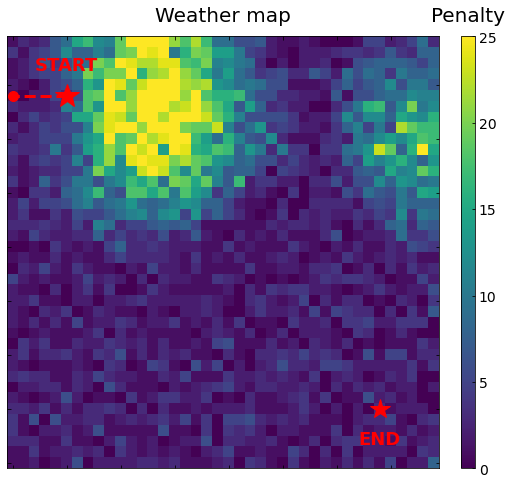

 :  Test return is <-2353.675613>
Training game 1 / 1000 [t=2.70s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -0.03      0.05      0.01     -0.09     -0.03     -0.07     -0.16     -0.15     -0.16
Training game 2 / 1000 [t=5.39s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -0.21     -0.10     -0.13     -0.25     -0.14     -0.18     -0.32     -0.31     -0.33
Training game 3 / 1000 [t=8.12s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -0.34     -0.28     -0.37     -0.41     -0.30     -0.43     -0.56     -0.54     -0.59
Training game 4 / 1000 [t=10.79s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -0.68     -0.58     -0.64     -0.73     -0.54     -0.68     -0.87     -0.81     -0.87
Training game 5 / 1000 [t=13.90s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1

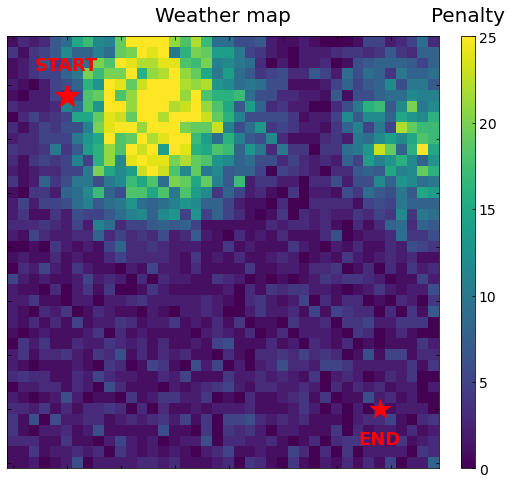

 :  Test return is <-100.000000>
Training game 16 / 1000 [t=44.04s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -8.46     -8.09     -8.49     -8.05     -7.34     -8.30     -8.71     -8.42     -9.01
Training game 17 / 1000 [t=46.42s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -8.61     -8.30     -8.81     -8.15     -7.47     -8.57     -8.85     -8.64     -9.32
Training game 18 / 1000 [t=48.79s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
   -9.72     -9.41     -9.94     -9.19     -8.49     -9.64     -9.87     -9.60    -10.30
Training game 19 / 1000 [t=51.17s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -10.57    -10.23    -10.80     -9.98     -9.26    -10.49    -10.66    -10.41    -11.19
Training game 20 / 1000 [t=53.74s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)  

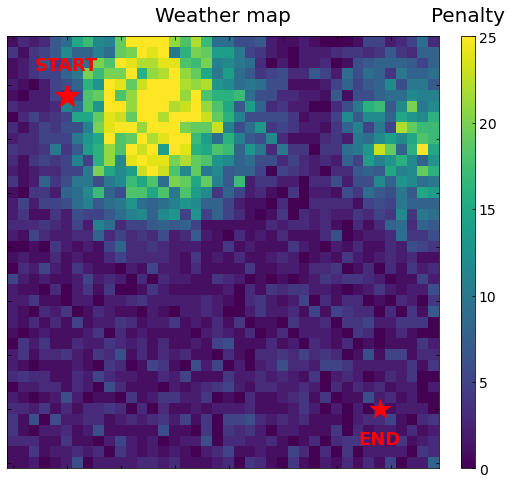

 :  Test return is <-100.000000>
Training game 31 / 1000 [t=85.45s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -23.39    -22.94    -23.75    -21.68    -20.68    -22.55    -22.05    -21.76    -23.13
Training game 32 / 1000 [t=88.11s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -22.66    -22.30    -23.17    -20.90    -19.93    -21.87    -21.21    -20.94    -22.32
Training game 33 / 1000 [t=90.74s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -27.73    -27.34    -28.24    -25.98    -25.00    -26.98    -26.33    -26.02    -27.38
Training game 34 / 1000 [t=93.18s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -22.65    -22.33    -23.36    -20.92    -20.04    -22.11    -21.29    -21.16    -22.70
Training game 35 / 1000 [t=95.65s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)  

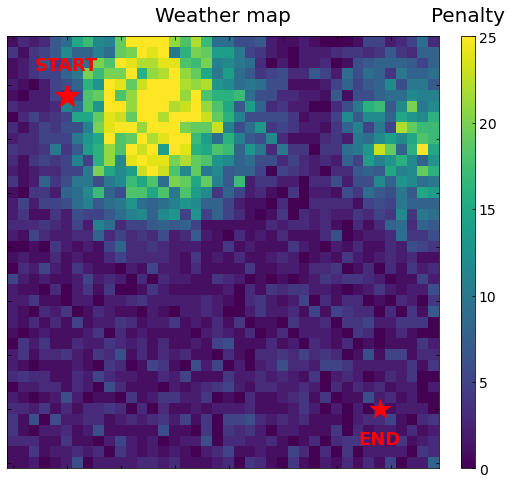

 :  Test return is <-100.000000>
Training game 46 / 1000 [t=125.55s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -35.51    -35.23    -36.49    -33.90    -33.08    -35.38    -34.44    -34.46    -36.14
Training game 47 / 1000 [t=127.89s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -31.28    -30.97    -32.19    -29.67    -28.80    -31.02    -30.22    -30.20    -31.78
Training game 48 / 1000 [t=130.27s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -39.51    -39.05    -40.12    -37.84    -36.79    -38.89    -38.17    -37.98    -39.46
Training game 49 / 1000 [t=132.64s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -27.07    -26.85    -28.16    -25.64    -24.82    -27.10    -26.20    -26.23    -27.82
Training game 50 / 1000 [t=135.19s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1,

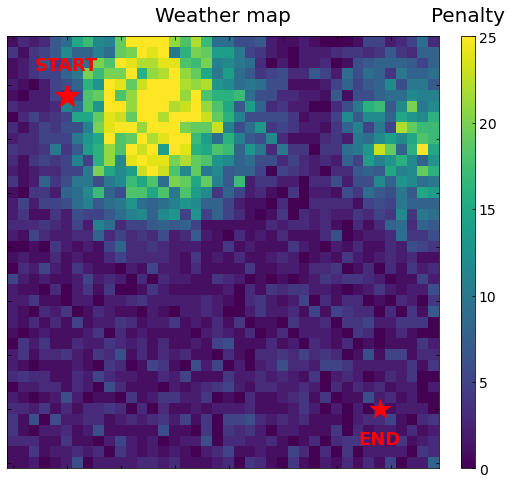

 :  Test return is <-100.000000>
Training game 61 / 1000 [t=165.11s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -32.40    -31.97    -33.11    -31.02    -29.90    -32.00    -31.28    -31.16    -32.53
Training game 62 / 1000 [t=167.51s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -34.28    -33.87    -35.14    -32.79    -31.71    -33.97    -33.00    -32.95    -34.48
Training game 63 / 1000 [t=170.15s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -44.22    -43.67    -44.74    -42.62    -41.41    -43.50    -42.64    -42.47    -43.84
Training game 64 / 1000 [t=172.65s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -37.95    -37.62    -38.87    -36.49    -35.51    -37.79    -36.64    -36.72    -38.27
Training game 65 / 1000 [t=175.03s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1,

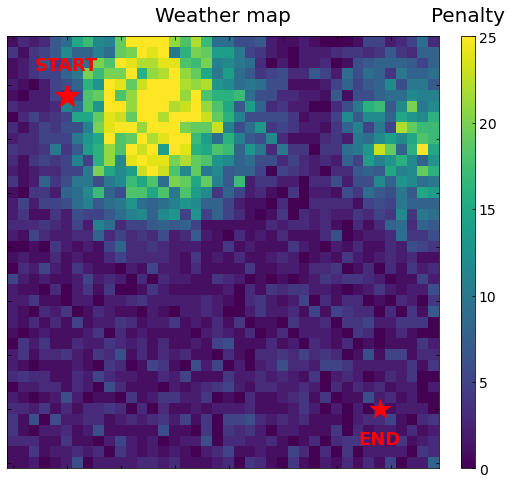

 :  Test return is <-100.000000>
Training game 76 / 1000 [t=206.46s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -43.54    -43.57    -45.30    -42.38    -41.75    -44.33    -42.89    -43.31    -45.12
Training game 77 / 1000 [t=209.24s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -41.87    -41.91    -43.62    -40.66    -40.01    -42.56    -41.10    -41.48    -43.26
Training game 78 / 1000 [t=211.79s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -52.40    -52.22    -53.75    -51.20    -50.38    -52.72    -51.64    -51.86    -53.44
Training game 79 / 1000 [t=214.31s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -48.06    -48.13    -49.85    -47.10    -46.49    -49.02    -47.73    -48.18    -49.94
Training game 80 / 1000 [t=216.81s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1,

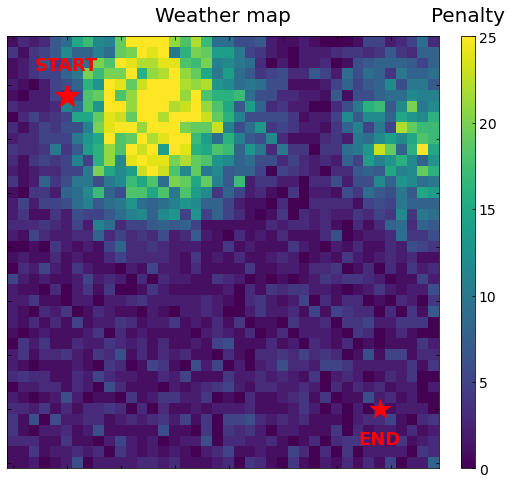

 :  Test return is <-100.000000>
Training game 91 / 1000 [t=247.97s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -41.16    -40.98    -42.15    -39.89    -38.86    -40.93    -39.86    -40.09    -41.38
Training game 92 / 1000 [t=250.45s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -48.33    -48.07    -49.20    -47.00    -45.91    -47.96    -47.03    -47.20    -48.45
Training game 93 / 1000 [t=252.95s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -56.45    -56.22    -57.47    -55.44    -54.46    -56.57    -55.84    -56.09    -57.42
Training game 94 / 1000 [t=255.40s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -48.09    -48.09    -49.50    -47.34    -46.59    -48.85    -48.02    -48.50    -49.97
Training game 95 / 1000 [t=257.76s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1,

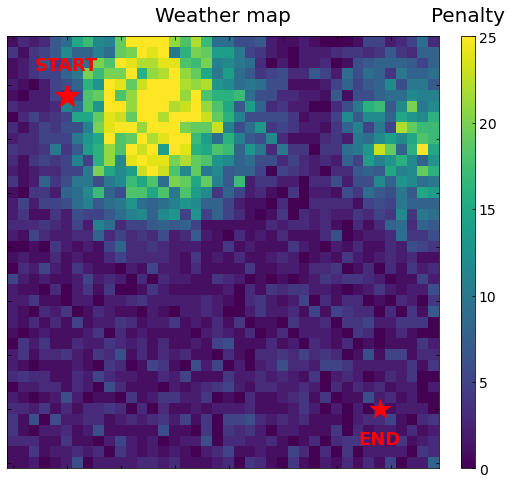

 :  Test return is <-100.000000>
Training game 106 / 1000 [t=287.75s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -65.21    -65.19    -66.73    -64.41    -63.67    -66.07    -65.07    -65.62    -67.23
Training game 107 / 1000 [t=290.08s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -54.45    -54.55    -56.25    -53.68    -53.06    -55.60    -54.40    -55.07    -56.80
Training game 108 / 1000 [t=292.64s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -63.58    -63.79    -65.61    -62.70    -62.23    -64.89    -63.25    -64.05    -65.95
Training game 109 / 1000 [t=295.03s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)    (1, 0)    (1, 1)
  -49.10    -49.37    -51.28    -48.33    -47.86    -50.59    -48.93    -49.78    -51.72
Training game 110 / 1000 [t=297.42s]
(-1, -1)   (-1, 0)   (-1, 1)   (0, -1)    (0, 0)    (0, 1)   (1, -1)  

KeyboardInterrupt: 

In [376]:


## Configure

num_train_games = 1000
num_train_turns = 40
learning_rate   = 1e-3
test_interval   = 15

%matplotlib inline

## Set up

loss_fcn  = keras.losses.mse
optimizer = keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=5)
models    = [q1_model, q2_model]


## Train

start_time = time.time()
sys.stdout.write(f"\rBegin training\n")
for game_idx in range(num_train_games) :
    if game_idx % test_interval == 0 :
        test_return, test_return_stderr, trajectory = get_test_score(q1_model, q2_model, show=True)
        sys.stdout.write(f" :  Test return is <{test_return:.6f}>\n")
        #sys.stdout.write(f"Test trajectory is {trajectory[:20]}...\n")
        pass
    
    sys.stdout.write(f"\rTraining game {game_idx+1} / {num_train_games} [t={time.time()-start_time:.2f}s]\n")
    sys.stdout.flush()
    
      # initialise game
    #storms, weather_board = get_new_game()
    storms        = [g for g in test_games[0][0]]
    weather_board = test_games[0][1].copy()
    r_agent = np.array([np.random.randint(horizontal_max), np.random.randint(vertical_max)])
    #r_agent = r_start.copy()
    
      # execute turns until we reach max, or the game ends
    trajectory, terminal_state, turn_idx = [r_agent], False, 0
    while(turn_idx) < num_train_turns :
        
          # get exploration action
        action = get_exploration_action(r_agent)

          # perform action to get reward and next state
        reward, storms_p, weather_board_p, r_agent_p = perform_action(storms, weather_board, r_agent, action)
        terminal_state = True if is_terminal(r_agent_p) else False
        
          # shuffle action-value models
        np.random.shuffle(models)
        q1_model, q2_model = models
        
          # use q1_model to determine best next action 
        action_p = get_greedy_action(weather_board_p, r_agent_p, q1_model)
        
          # prepare data for passing through models
        normed_weather_board   = prepare_weather_board_for_model(weather_board)
        weather_boards         = np.array([normed_weather_board])
        r_agents               = np.array([r_agent/r_norm      ])
        actions                = np.array([action              ])
        normed_weather_board_p = prepare_weather_board_for_model(weather_board_p)
        weather_boards_p       = np.array([normed_weather_board_p])
        r_agents_p             = np.array([r_agent_p/r_norm      ])
        actions_p              = np.array([action_p              ])
        
        weather_boards_t       = np.array([normed_weather_board for i in range(9)])
        r_agents_t             = np.array([r_agent/r_norm       for i in range(9)])
        #model_inputs_t         = [weather_boards_t, r_agents_t, action_list]
        model_inputs_t         = [r_agents_t, action_list]
        
        if turn_idx == 0 :
            print('  '.join([f"{a[0], a[1]}".rjust(8) for a in action_list]))
            print('  '.join([f"{z:.2f}".rjust(8) for z in 0.5*(q1_model.predict(model_inputs_t)+q2_model.predict(model_inputs_t)).flatten()]))
        
          # get empirical return using bootstrap for expected next state return
        #max_next_value = 0. if terminal_state else q2_model.predict([weather_boards_p, r_agents_p, actions_p])[0][0]
        max_next_value = 0. if terminal_state else q2_model.predict([r_agents_p, actions_p])[0][0]
        if not np.isfinite(max_next_value) :
            print(f"weather_boards_p.sum() = {weather_boards_p.sum()}")
            print(f"r_agents_p = {r_agents_p}")
            print(f"actions_p = {actions_p}")
            raise ValueError(f"Model action-value is {max_next_value}")
        empirical_return = reward + gamma * max_next_value

          # calculate difference between model and empirical return, and apply gradient update
        with tf.GradientTape() as tape:
            #pred_return = q1_model([weather_boards, r_agents, actions], training=True)
            pred_return = q1_model([r_agents, actions], training=True)
            loss_value  = loss_fcn(pred_return, empirical_return)
            grads       = tape.gradient(loss_value, q1_model.trainable_weights)
            #print(f'Sum grads is {np.sum([arr.numpy().sum() for arr in grads])}')
            optimizer.apply_gradients(zip(grads, q1_model.trainable_weights))
            
          # update current states and turn index, ready for the next turn
        storms, weather_board, r_agent = storms_p, weather_board_p, r_agent_p
        trajectory.append(r_agent)
        turn_idx += 1
        
sys.stdout.write(f"\nTraining complete [t={time.time()-start_time:.2f}s]\n")
sys.stdout.flush()


<IPython.core.display.Javascript object>


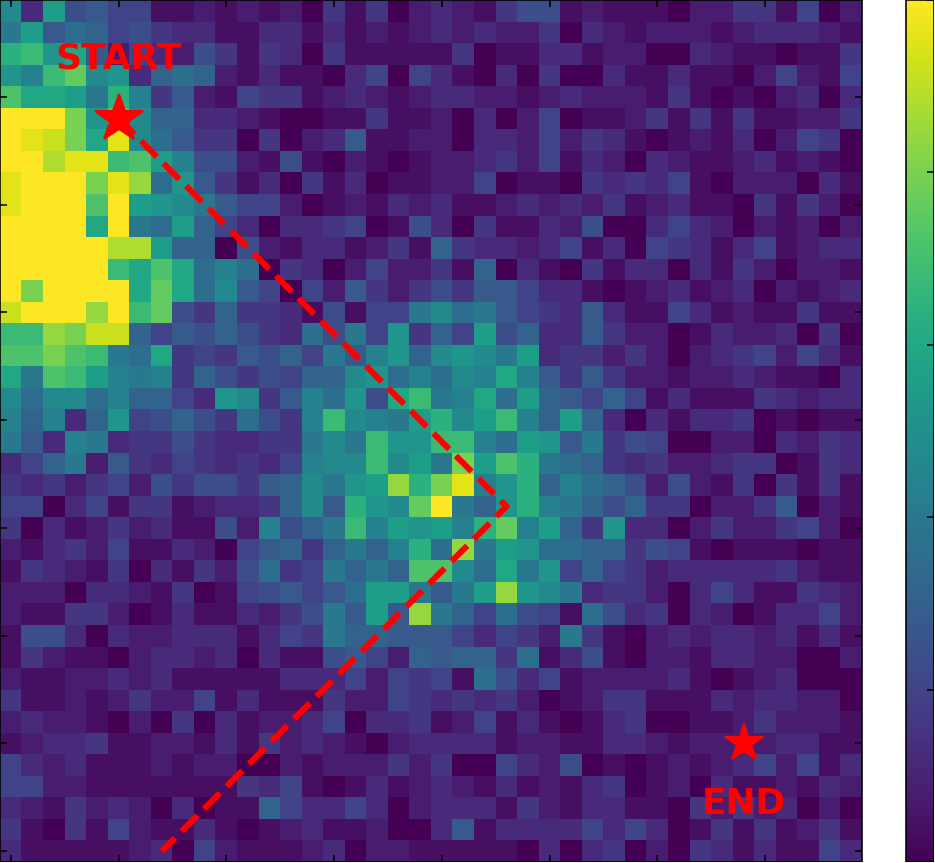

done


In [264]:
###
###  Animate test game
###

  # Configurable constants
fps = 8

  # Use mpl notebook backend for animated plots
%matplotlib notebook

  # Create figure object to iterate and form an animation
storms, weather_board = get_new_game()
fig, ax, cax, im, line = create_weather_plot(weather_board)
#r_agent    = r_start.copy()
r_agent    = np.array([np.random.randint(horizontal_max), np.random.randint(vertical_max)])
trajectory = [r_agent]
    
  # Create method which applied frame updates by iterating the weather and overwriting im object
def animate(i) :
    global storms, weather_board, r_agent, trajectory, q1_model, q2_model
    if is_terminal(r_agent) :
        storms, weather_board = get_new_game()
        #r_agent    = r_start.copy()
        r_agent = np.array([np.random.randint(horizontal_max), np.random.randint(vertical_max)])
        trajectory = [r_agent]
        line.set_data([], [])
        im.set_array(weather_board)
    else :
        action = get_greedy_action(weather_board, r_agent, q1_model, q2_model)
        reward, storms, weather_board, r_agent = perform_action(storms, weather_board, r_agent, action)
    im.set_array(weather_board)
    line.set_data([r[0] for r in trajectory], [r[1] for r in trajectory])
    trajectory.append(r_agent)
    return [im, line]
    #return [line]
    
  # Create mpl animation object
ani = animation.FuncAnimation(fig, animate, frames=150, interval=1000/fps, repeat=True)

  # Show animation
plt.show(ani)
print("done")



In [370]:
help(optimizer)

Help on SGD in module keras.optimizer_v2.gradient_descent object:

class SGD(keras.optimizer_v2.optimizer_v2.OptimizerV2)
 |  SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD', **kwargs)
 |  
 |  Gradient descent (with momentum) optimizer.
 |  
 |  Update rule for parameter `w` with gradient `g` when `momentum` is 0:
 |  
 |  ```python
 |  w = w - learning_rate * g
 |  ```
 |  
 |  Update rule when `momentum` is larger than 0:
 |  
 |  ```python
 |  velocity = momentum * velocity - learning_rate * g
 |  w = w + velocity
 |  ```
 |  
 |  When `nesterov=True`, this rule becomes:
 |  
 |  ```python
 |  velocity = momentum * velocity - learning_rate * g
 |  w = w + momentum * velocity - learning_rate * g
 |  ```
 |  
 |  Args:
 |    learning_rate: A `Tensor`, floating point value, or a schedule that is a
 |      `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
 |      that takes no arguments and returns the actual value to use. The
 |      learning rate. D

In [262]:
line